# Green Sentiment

by Lucas Kiesel and Julian Menon

In this notebook, we combine the scores of both the image- and sentiment analysis to calculate and visualize their correlation. First, let's load both datasets.

In [77]:
import json
import pandas as pd

# green scores

green_scores = {}
with open('../green_scores/green_scores.json', 'r', encoding='utf-8') as file:
    
    # these are our green scores
    # see our "step_by_step_explanation" for more details
    green_scores = json.load(file)


#print(green_scores)



# happiness scores

# this extracts the scores normalized by the amount of positive and negative posts+comments
# however, we need to normalize these scores by their distribution as well to make them better match with the green scores
extracted_scores = pd.read_csv('../happiness_scores/city_sentiment_scored.csv')[['city','sentiment_score']]

# mean
score_mean = extracted_scores['sentiment_score'].mean()

# standard deviation
deviation_sum = 0

for _, city_entry in extracted_scores.iterrows():
    deviation_sum += (city_entry['sentiment_score']-score_mean)**2
        
score_std_dev = (deviation_sum/len(extracted_scores['sentiment_score']))**(1/2)


# normalization
happiness_scores = {}
for _, city_entry in extracted_scores.iterrows():
    
    happiness_scores[city_entry['city'].capitalize()] = (city_entry['sentiment_score']-score_mean)/score_std_dev

#print(happiness_scores)

We made some violin plots to visualize the sentiment distribution of the posts/comments accross the cities. The thickness of the violins indicates how many posts there are. We filtered for positve and negative posts; we do not cosinder neutral posts: 


![Violine City Plots...](../happiness_scores/violin_with_post_sentiment.png)

As we can see from the graph, there are overall more negative posts/comments than positive ones and Wolfsburg has especially few posts in general. 

Now that both datasets are loaded, lets merge them together. 

In [73]:
# this is a dirty fix: we used the englisch subreddit for Muenchen = Munich
happiness_scores['Muenchen'] = happiness_scores['Munich']
del happiness_scores['Munich']

# store everything in a combined score map. The two scores are tuples (happiness_score, green_score)
combined_score_map = {}
for city_name in happiness_scores.keys():
    
    if(city_name in green_scores):
        combined_score_map[city_name] = (happiness_scores[city_name], green_scores[city_name])
        
    else:
        print(f"Did not find city name {city_name} in green scores!")
        
#print(combined_score_map)

Finally, we visualize the results.

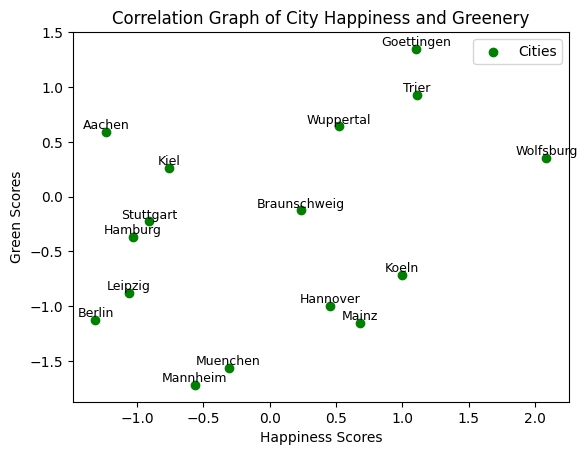

Correlation: 0.3607753930770206


In [74]:
import matplotlib.pyplot as plt
import numpy as np


# convert data to the correct format
x_happiness_scores = []
y_green_scores = []
node_labels = []

for city_name in combined_score_map.keys():
    x_happiness_scores.append(combined_score_map[city_name][0])
    y_green_scores.append(combined_score_map[city_name][1])
    node_labels.append(city_name)

# plot
plt.scatter(x_happiness_scores, y_green_scores, label='Cities', color='green', marker='o')
plt.xlabel('Happiness Scores')
plt.ylabel('Green Scores')
plt.title('Correlation Graph of City Happiness and Greenery')
plt.legend()

# add node label city names
for i in range(len(node_labels)):
    plt.text(x_happiness_scores[i], y_green_scores[i], node_labels[i], fontsize=9, ha='center', va='bottom')

plt.show()

# calculate the correlation coefficient to underline the results
x_happiness_scores = np.array(x_happiness_scores)
y_green_scores = np.array(y_green_scores)

correlation = ((x_happiness_scores - x_happiness_scores.mean()) * (y_green_scores - y_green_scores.mean())).sum()
correlation /= (((x_happiness_scores - x_happiness_scores.mean())**2).sum() * ((y_green_scores - y_green_scores.mean())**2).sum())**(1/2)

print(f"Correlation: {correlation}")


As we can conclude from the graph above, there is no visual correlation for our data linking the green scores to better online sentiment. The Pearson correlation efficient, however, shows at least weak positive correlation. 
There is a possibility that no correlation between greener cities and happy sentiment exists. However, we thought of 2 possible explanations for why the signal is weak, despite a positive correlation possibly existing anyway: 
- reddit is an instable source of posts: the topics vary a lot and seem mostly random
- the subreddits have vastly different amounts of posts and comments with some subreddits being very active (having thousands of posts), while Wolfsburg only has 38 posts and 79 comments

On another note, Wolfsburg is an outlier, since there are very few posts and comments. So, let us recalculate the correlation without the outlier:

In [75]:
x_happiness_scores = np.delete(x_happiness_scores, np.where(np.array(node_labels) == "Wolfsburg"))
y_green_scores = np.delete(y_green_scores, np.where(np.array(node_labels) == "Wolfsburg"))

correlation = ((x_happiness_scores - x_happiness_scores.mean()) * (y_green_scores - y_green_scores.mean())).sum()
correlation /= (((x_happiness_scores - x_happiness_scores.mean())**2).sum() * ((y_green_scores - y_green_scores.mean())**2).sum())**(1/2)

print(f"Correlation: {correlation}")

Correlation: 0.3130289380567756


The true correlation seems the be a bit weaker stil. It is, nonetheless, a weak positive correlation. 

There are some additional cosiderations concerning our result:
- our sample size of 18 cities is small
- even bigger cities might have insignificantly small subreddits
- we use the mixed language model Xlmroberta classifying both german and english posts alike. Using different models might influence the result


We were supposed to give a recommendation for actions to take based on our results. Since our correlation is only weak, we cannot give a definite answer. Based on the weak positive correlation, it seems like expanding the greenary might have a positive effect on the sentiment of the people. The greenary might, in turn, indicate increased happiness. However, this is only speculation.